In [2]:
!git clone https://huggingface.co/datasets/DTU54DL/common-accent "../accent-dataset/cacc"

fatal: destination path '../accent-dataset/cacc' already exists and is not an empty directory.


In [3]:
import os
import pandas as pd

common_accent_dir = "../accent-dataset/cacc"

df_train = pd.read_parquet(os.path.join(common_accent_dir, "data/train-00000-of-00001-fc6c4977ae9f62c1.parquet"))
df_test = pd.read_parquet(os.path.join(common_accent_dir, "data/test-00000-of-00001-53b88232efc0bf7e.parquet"))

In [4]:
english_varieties = [
    "India and South Asia (India, Pakistan, Sri Lanka)",
    "German English, Non-native speaker",
    "Southern African (South Africa, Zimbabwe, Namibia)",
    "Filipino",
    "Singaporean English",
    "Hong Kong English"
]

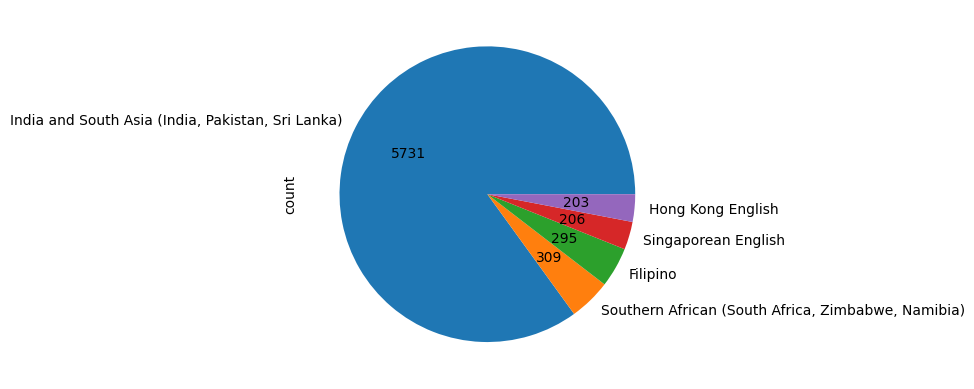

In [5]:
filtered_df = df_train[df_train["accent"].isin(english_varieties)]
x = ['line', 'bar', 'barh', 'kde', 'density', 'area', 'hist', 'box', 'pie', 'scatter', 'hexbin']
filtered_df.accent.value_counts().plot(kind='pie',
                                       autopct=lambda p: f'{p * filtered_df.accent.value_counts().sum() / 100:.0f}');

In [6]:
import torchaudio
import io
from tqdm import tqdm

target_sr = 16000

normal_data_dir = os.path.join(common_accent_dir, "wavs")
os.makedirs(normal_data_dir, exist_ok=True)
for accent in filtered_df.accent.unique():
    accent_dir = os.path.join(normal_data_dir, accent.lower())
    os.makedirs(accent_dir, exist_ok=True)
    with open(os.path.join(accent_dir, "accent.txt"), "w") as f:
        f.write(accent)

duration_info_dict = {}
rates_info_dict = {}
sample_rates = []

for i, (au_bytes, sentence, accent) in tqdm([*filtered_df.iterrows()]):
    audio_tensor, sample_rate = torchaudio.load(io.BytesIO(au_bytes['bytes']))
    torchaudio.functional.resample(audio_tensor, sample_rate, target_sr)

    if accent not in duration_info_dict.keys():
        duration_info_dict[accent] = []
    if accent not in rates_info_dict.keys():
        rates_info_dict[accent] = []

    sample_rates.append(sample_rate)
    duration_info_dict[accent].append(audio_tensor.size(-1) / sample_rate)
    rates_info_dict[accent].append(sample_rate)

    # Save as .wav file
    accent_dir = os.path.join(normal_data_dir, accent.lower())
    filepath = os.path.join(accent_dir, f"{i}.wav")
    torchaudio.save(filepath, audio_tensor, sample_rate)

100%|██████████| 6744/6744 [00:31<00:00, 211.24it/s]


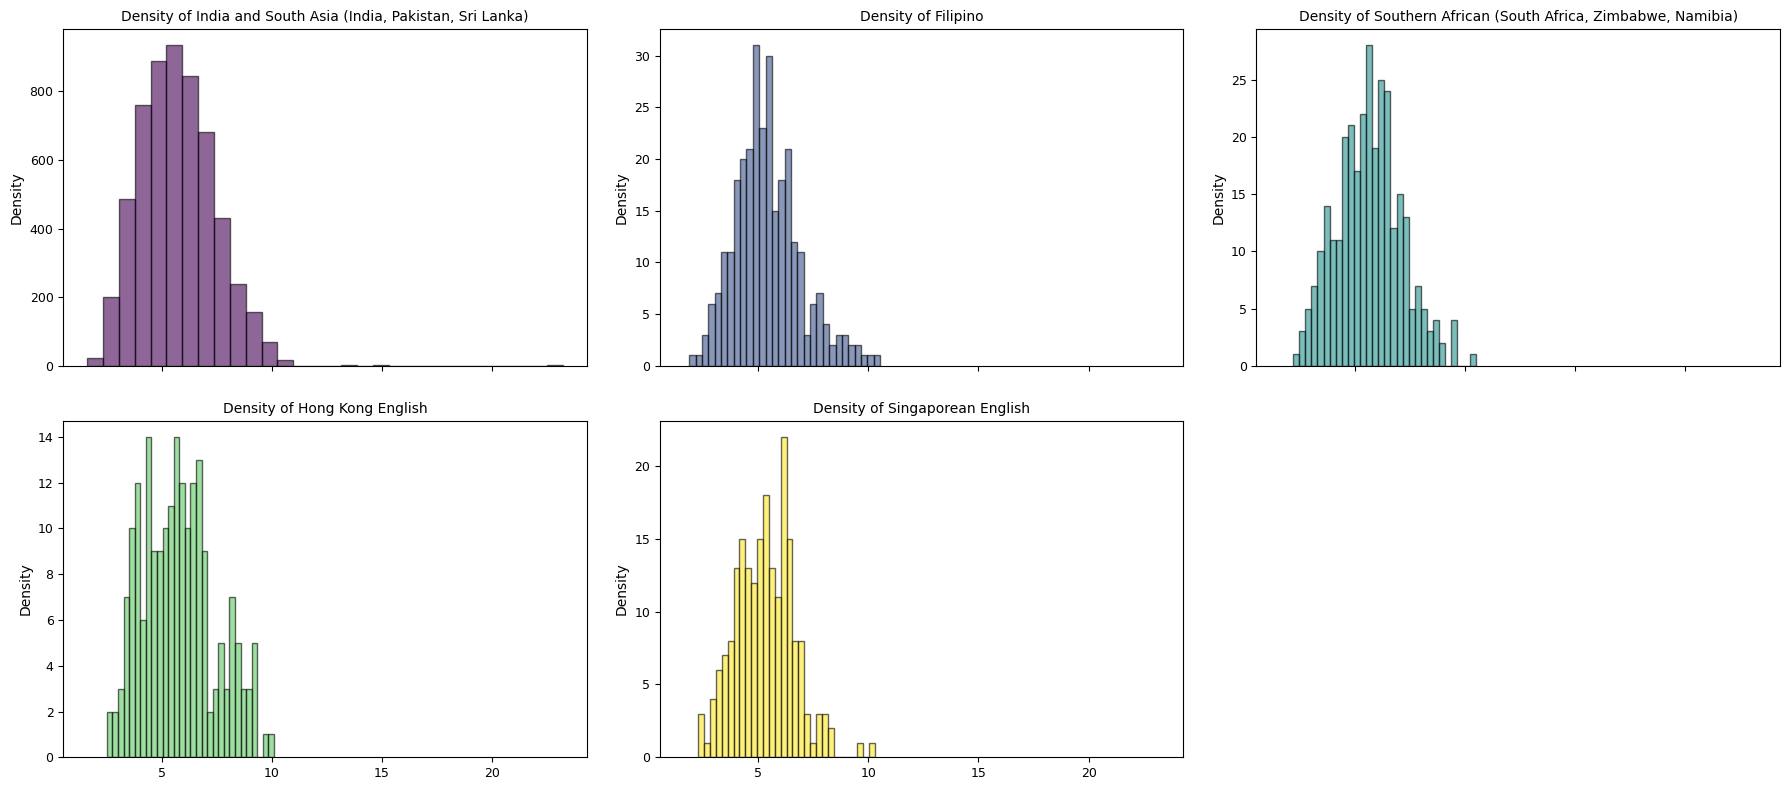

In [7]:
import numpy as np
import matplotlib.pyplot as plt

num_plots = len(duration_info_dict)
rows = (num_plots + 2) // 3  # Ensure enough rows for all plots
fig, axes = plt.subplots(rows, 3, figsize=(18, 4 * rows), sharex=True)

colors = plt.cm.viridis(np.linspace(0, 1, num_plots))  # Generate distinct colors

# Flatten axes array and hide unused subplots
axes = axes.flatten()
for i in range(len(axes)):
    if i >= num_plots:
        fig.delaxes(axes[i])  # Remove extra empty subplots

for ax, (key, values), color in zip(axes, duration_info_dict.items(), colors):
    values = np.array(values)
    ax.hist(values, bins=30, density=False, alpha=0.6, edgecolor='black', color=color, log=False)
    ax.set_title(f"Density of {key}", fontsize=10)
    ax.set_ylabel("Density", fontsize=10)
    ax.tick_params(axis='both', labelsize=9)

# Adjust layout to prevent text overlap
plt.tight_layout(h_pad=2, w_pad=2)
plt.show()
